# Bevan Joubert

## Project 7 - Computer Vision

In [1]:
# Import the required packages.
# Standard Packages
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
# Data preparation.
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
# Image Processing
from skimage.color import rgb2gray
from skimage.filters import gaussian
# Trnsorflow and Keras
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalMaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras import optimizers
# Performance Metrics
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
# Do some formatting of the page.
from IPython.core.interactiveshell import InteractiveShell
pd.options.display.float_format = '{:,.2f}'.format
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:0.4f}'.format)

C:\Anaconda3\lib\site-packages\statsmodels\tools\_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
# If running locally with GPU. Do this to prevent errors due to GPU memory limit.
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
   tf.config.experimental.set_memory_growth(physical_devices[0], True)

### 1 Import and Visualize Data

In [3]:
# Import the data.
images = np.load("images.npy")
labels = pd.read_csv("labels.csv")

In [4]:
# View the shape of the images array.
images.shape

(4750, 128, 128, 3)

In [5]:
images[0, 0, 0]

array([35, 52, 78], dtype=uint8)

In [6]:
# View the shape of the labels array.
labels.shape

(4750, 1)

In [7]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4750 entries, 0 to 4749
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Label   4750 non-null   object
dtypes: object(1)
memory usage: 37.2+ KB


In [8]:
labels.nunique()

Label    12
dtype: int64

In [9]:
# The labels are grouped by Label in the csv file, get the positions where each new group begins.
# This will allow us to view information from each group, in both the labels and images arrays, more easily.
def getClassPositions(classList):
    classPositions = []
    classPositions.append(0)
    currentClass = classList[0]
    for i in range(len(classList)):
        if(currentClass != classList[i]):
            classPositions.append(i)
            currentClass = classList[i]
    return classPositions
            
classPositions = getClassPositions(labels['Label'])
classPositions

[0, 496, 971, 1202, 1423, 2034, 2424, 2711, 3227, 3612, 3833, 4096]

In [10]:
# Display the labels.
labels.iloc[classPositions]

Label
0     Small-flowered Cranesbill
496                     Fat Hen
971             Shepherds Purse
1202               Common wheat
1423           Common Chickweed
2034                   Charlock
2424                   Cleavers
2711          Scentless Mayweed
3227                 Sugar beet
3612                      Maize
3833                Black-grass
4096           Loose Silky-bent

In [11]:
# Convert the labels dataframe to a list,it will be easier to handle.
labelsList = list(labels['Label'])

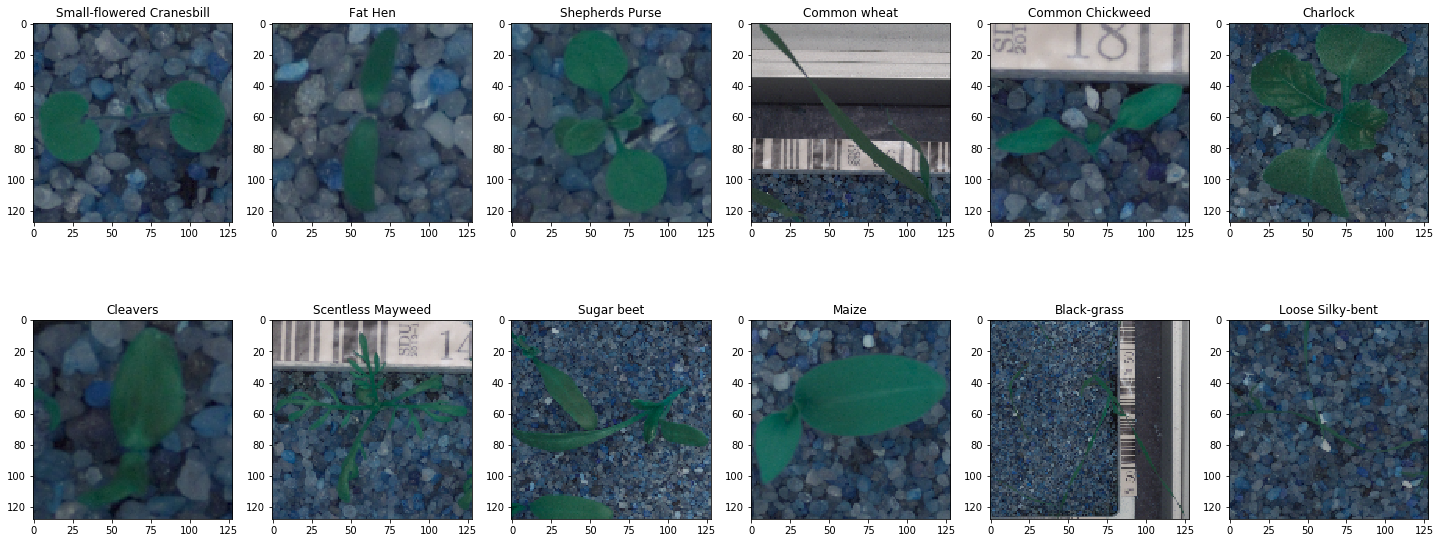

In [12]:
# Print the first image from every class.
def printImages(imageArray, labelArray, positions, colorMap=None, picSize=5):
    ''' Prints the images at "positions" in rows of 6 images '''
    totalImages = len(positions)
    imageCount = 0
    rows = math.ceil(totalImages/6)
    lastRowCols = totalImages%6
    
    f, ax = plt.subplots(rows, 6, figsize=(25,(rows*picSize)))
    
    if (rows>1):
        for i in range(rows):
            for j in range(6):
                ax[i,j].imshow(imageArray[positions[imageCount]], colorMap)
                ax[i,j].title.set_text(labelArray[positions[imageCount]])
                imageCount = imageCount + 1
                if(imageCount == (totalImages)):
                    return
    else:
        for i in range(6):
            ax[i].imshow(imageArray[positions[imageCount]], colorMap)
            ax[i].title.set_text(labelArray[positions[imageCount]])
            imageCount = imageCount + 1
            if(imageCount == (totalImages)):
                return
        
            
printImages(images, labelsList, classPositions)

In [13]:
# If you want to see more images of each class.
# Print the first 5 images from every class.
'''
for i, pos in enumerate(classPositions):
    f, ax = plt.subplots(1, 5, figsize=(25,4))
    f.suptitle(labels['Label'][pos], fontsize=12)
    for j in range(5):
        ax[j].imshow(images[pos+j])
'''

"\nfor i, pos in enumerate(classPositions):\n    f, ax = plt.subplots(1, 5, figsize=(25,4))\n    f.suptitle(labels['Label'][pos], fontsize=12)\n    for j in range(5):\n        ax[j].imshow(images[pos+j])\n"

### 2 Data Preprocessing

In [14]:
# Scale the images from int of 0-255 to a float of 0-1.
images_rgb = images.copy()
images_rgb = images_rgb.astype('float32')
images_rgb = images_rgb/255
images_rgb[0,0,0]

array([0.13725491, 0.20392157, 0.30588236], dtype=float32)

In [15]:
# Perform Gaussian blurring on the images.
for i in range(images_rgb.shape[0]):
    images_rgb[i] = gaussian(images_rgb[i], sigma=1.0, multichannel=True)

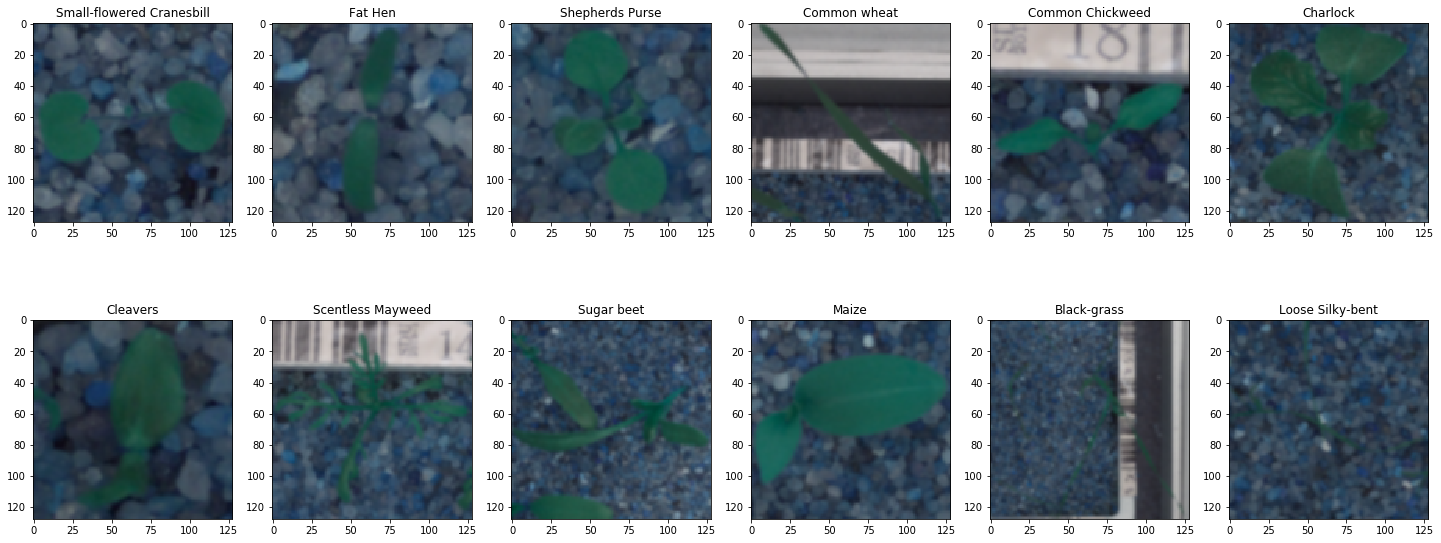

In [16]:
# Print the gaussian blurred first image from every class.
printImages(images_rgb, labelsList, classPositions)

In [17]:
# Sometimes CNNs only need grayscale images, so create grayscale images as well.
# Convert the image array to gray scale.
images_gs = rgb2gray(images)
images_gs.shape

(4750, 128, 128)

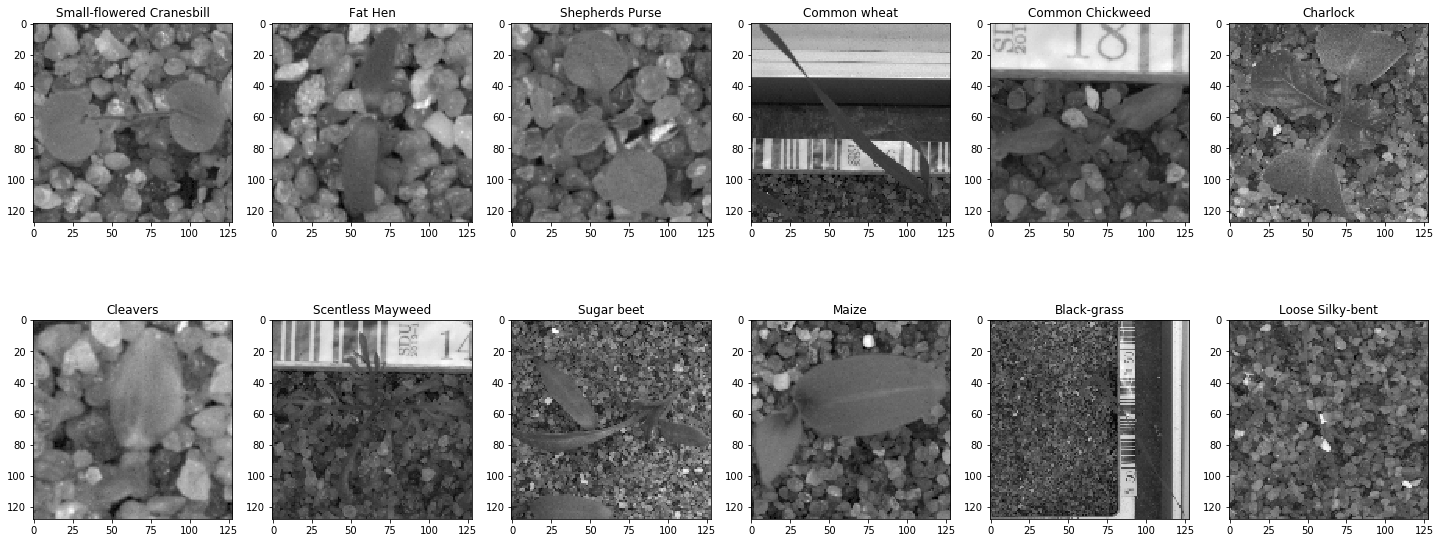

In [18]:
# Print the first image from every class in grayscale.
printImages(images_gs, labelsList, classPositions, 'gray')

In [19]:
# The rgb2gray function converts the images from an int between 0-255 to a float between 0-1.
# Confirms this.
images_gs[0, 0, 0] # Show the first pixel value to confirm

0.19710627450980395

In [20]:
# Perform Gaussian blurring on the grayscale images.
for i in range(images_gs.shape[0]):
    images_gs[i] = gaussian(images_gs[i], sigma=1.0, multichannel=True)

In [21]:
# Confirm that the pixel values are still floating point and between 0 and 1.
images_gs[0, 0, 0] # Show the first pixel value to confirm

0.19141778654732225

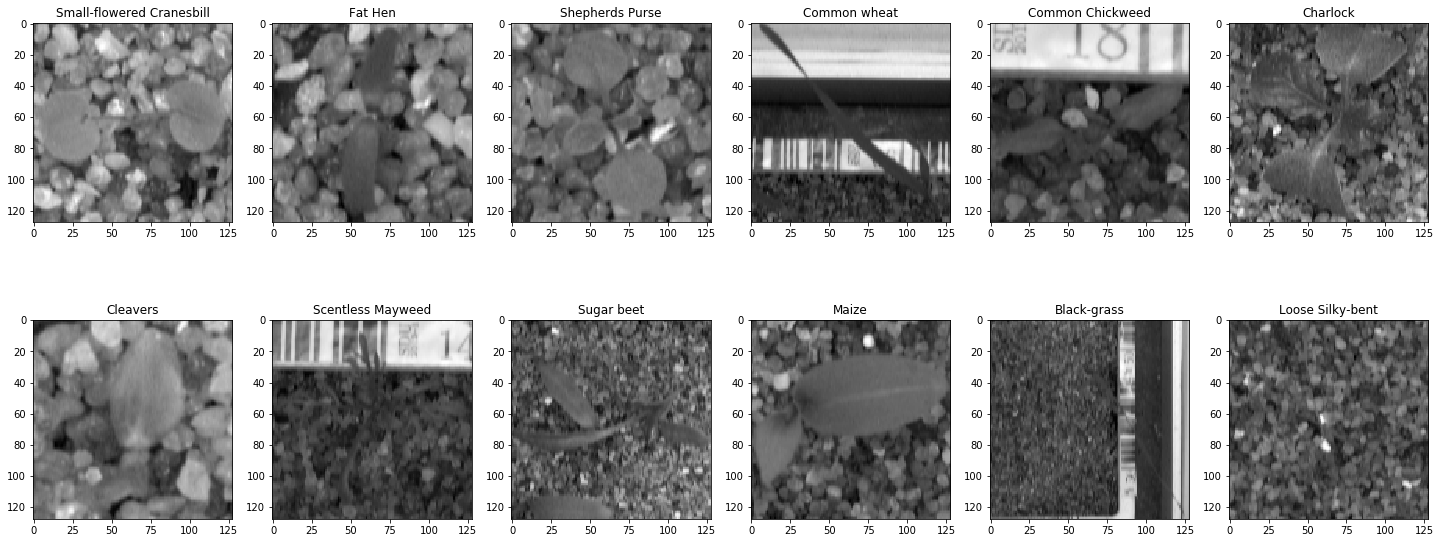

In [22]:
# Print the grayscale gaussian blurred first image from every class.
printImages(images_gs, labelsList, classPositions, 'gray')

In [23]:
# Data is still floating point with values between 0 and 1, so there is no need for normalization.
images_gs[0,0,0]

0.19141778654732225

### 3a Make Data Compatible (Grayscale)

In [23]:
# Display the labels.
labels.iloc[classPositions]

Label
0     Small-flowered Cranesbill
496                     Fat Hen
971             Shepherds Purse
1202               Common wheat
1423           Common Chickweed
2034                   Charlock
2424                   Cleavers
2711          Scentless Mayweed
3227                 Sugar beet
3612                      Maize
3833                Black-grass
4096           Loose Silky-bent

In [24]:
# Make a series to store the class names as they are in the current order.
classNames = pd.Series(np.array(labels.iloc[classPositions]['Label']))
classNames

0     Small-flowered Cranesbill
1                       Fat Hen
2               Shepherds Purse
3                  Common wheat
4              Common Chickweed
5                      Charlock
6                      Cleavers
7             Scentless Mayweed
8                    Sugar beet
9                         Maize
10                  Black-grass
11             Loose Silky-bent
dtype: object

In [25]:
# Rename the classes with alphabet letters in the order which they appear.
# This is not neccessary, but it will keep the columns in the same order as which the labels currently are when one hot encoding.
# Keeping the order will be handy later on when visualising predictions.
renameDict = {"Small-flowered Cranesbill":"A",
              "Fat Hen":"B",
              "Shepherds Purse":"C",
              "Common wheat":"D",
              "Common Chickweed":"E",
              "Charlock":"F",
              "Cleavers":"G",
              "Scentless Mayweed":"H",
              "Sugar beet":"I",
              "Maize":"J",
              "Black-grass":"K",
              "Loose Silky-bent":"L",}

In [26]:
# First one-hot encode the labels.
labels_ohe = labels.replace(renameDict)
labels_ohe = pd.get_dummies(labels_ohe)
labels_ohe.iloc[classPositions]

Label_A  Label_B  Label_C  Label_D  Label_E  Label_F  Label_G  Label_H  \
0           1        0        0        0        0        0        0        0   
496         0        1        0        0        0        0        0        0   
971         0        0        1        0        0        0        0        0   
1202        0        0        0        1        0        0        0        0   
1423        0        0        0        0        1        0        0        0   
2034        0        0        0        0        0        1        0        0   
2424        0        0        0        0        0        0        1        0   
2711        0        0        0        0        0        0        0        1   
3227        0        0        0        0        0        0        0        0   
3612        0        0        0        0        0        0        0        0   
3833        0        0        0        0        0        0        0        0   
4096        0        0        0        0        0        0        0        0   

      Label_I  Label_J  Label_K  Label_L  
0           0        0        0        0  
496         0        0        0        0  
971         0        0        0        0  
1202        0        0        0        0  
1423        0        0        0        0  
2034        0        0        0        0  
2424        0        0        0        0  
2711        0        0        0        0  
3227        1        0        0        0  
3612        0        1        0        0  
3833        0        0        1        0  
4096        0        0        0        1

In [27]:
# The labels_ohe dataframe must be converted to an array.
labels_array = labels_ohe.to_numpy()
labels_array[classPositions]

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]], dtype=uint8)

In [28]:
# Notic that the classes are in the same order as the labels, so printing label from each class makes an identity matrix.
# This is purely to aid visualization of predictions later on.

In [29]:
# Check the shape of the X data.
images_gs.shape

(4750, 128, 128)

In [30]:
# Split the data into training, validation sets.
X_train_gs, X_test_gs, y_train_gs, y_test_gs = train_test_split(images_gs, labels_array, test_size=0.3, random_state=9, stratify=labels_ohe)

In [31]:
# Splite the test data into validation and test datasets.
X_val_gs, X_test_gs, y_val_gs, y_test_gs = train_test_split(X_test_gs, y_test_gs, test_size=0.5, random_state=9, stratify=y_test_gs)

In [32]:
print("X_train shape:\t" + str(X_train_gs.shape))
print("y_train shape:\t" + str(y_train_gs.shape))
print("X_val shape:\t" + str(X_val_gs.shape))
print("y_val shape:\t" + str(y_val_gs.shape))
print("X_test shape:\t" + str(X_test_gs.shape))
print("y_test shape:\t" + str(y_test_gs.shape))

X_train shape:	(3325, 128, 128)
y_train shape:	(3325, 12)
X_val shape:	(712, 128, 128)
y_val shape:	(712, 12)
X_test shape:	(713, 128, 128)
y_test shape:	(713, 12)


In [33]:
# The X data must be reshaped to (:, 128, 128, 1)
X_train_gs = X_train_gs.reshape(X_train_gs.shape[0], X_train_gs.shape[1], X_train_gs.shape[2], 1)
X_val_gs = X_val_gs.reshape(X_val_gs.shape[0], X_val_gs.shape[1], X_val_gs.shape[2], 1)
X_test_gs = X_test_gs.reshape(X_test_gs.shape[0], X_test_gs.shape[1], X_test_gs.shape[2], 1)
print("X_train shape:\t" + str(X_train_gs.shape))
print("X_val shape:\t" + str(X_val_gs.shape))
print("X_test shape:\t" + str(X_test_gs.shape))

X_train shape:	(3325, 128, 128, 1)
X_val shape:	(712, 128, 128, 1)
X_test shape:	(713, 128, 128, 1)


In [34]:
# Confirm that the datatypes of the image arrays are floats.
print("X_train datatype:\t" + str(X_train_gs[0,0,0,0].dtype))
print("X_val datatype:\t\t" + str(X_val_gs[0,0,0,0].dtype))
print("X_test datatype:\t" + str(X_test_gs[0,0,0,0].dtype))

X_train datatype:	float64
X_val datatype:		float64
X_test datatype:	float64


In [35]:
# Confirm that image array values are between 0 and 1.
print("X_train min and max:\t" + str(X_train_gs.min()) + " " + str(X_train_gs.max()))
print("X_val min and max:\t" + str(X_val_gs.min()) + " " + str(X_val_gs.max()))
print("X_test min and max:\t" + str(X_test_gs.min()) + " " + str(X_test_gs.max()))

X_train min and max:	0.009992461448591804 1.0
X_val min and max:	0.008326959594799689 1.0
X_test min and max:	0.0065363094857638394 1.0


### 4a Model Building (Grayscale)

In [36]:
# Build the model.
model_gs = Sequential()
model_gs.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 1)))
model_gs.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model_gs.add(Flatten())
model_gs.add(Dense(128, activation="relu"))
model_gs.add(Dense(12, activation="softmax"))

In [37]:
# Compile the model.
model_gs.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [38]:
# View the model summary.
model_gs.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      320       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
flatten (Flatten)            (None, 492032)            0         
_________________________________________________________________
dense (Dense)                (None, 128)               62980224  
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1548      
Total params: 62,991,340
Trainable params: 62,991,340
Non-trainable params: 0
_________________________________________________________________


In [39]:
# Train the model.
history_gs = model_gs.fit(X_train_gs, y_train_gs, batch_size=32, epochs=10, validation_data=(X_val_gs, y_val_gs), verbose=1)

Train on 3325 samples, validate on 712 samples
Epoch 1/10
3325/3325 [==============================] - 18s 5ms/sample - loss: 2.8712 - accuracy: 0.1182 - val_loss: 2.4346 - val_accuracy: 0.1334
Epoch 2/10
3325/3325 [==============================] - 15s 4ms/sample - loss: 2.4007 - accuracy: 0.1302 - val_loss: 2.3848 - val_accuracy: 0.1419
Epoch 3/10
3325/3325 [==============================] - 15s 4ms/sample - loss: 2.3099 - accuracy: 0.1919 - val_loss: 2.3130 - val_accuracy: 0.1896
Epoch 4/10
3325/3325 [==============================] - 15s 4ms/sample - loss: 2.0166 - accuracy: 0.3149 - val_loss: 2.4247 - val_accuracy: 0.2205
Epoch 5/10
3325/3325 [==============================] - 15s 4ms/sample - loss: 1.4924 - accuracy: 0.5275 - val_loss: 2.5296 - val_accuracy: 0.2135
Epoch 6/10
3325/3325 [==============================] - 15s 4ms/sample - loss: 0.8856 - accuracy: 0.7362 - val_loss: 3.0380 - val_accuracy: 0.2388
Epoch 7/10
3325/3325 [==============================] - 15s 4ms/sample 

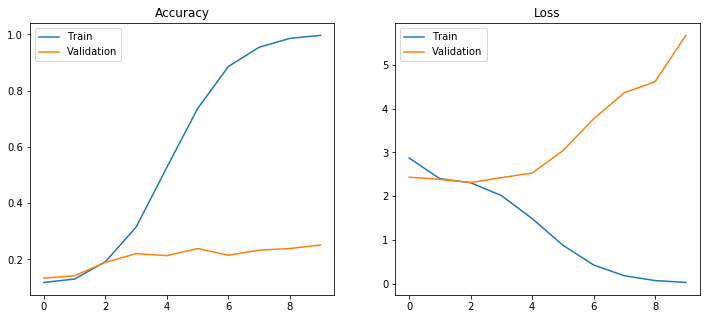

In [40]:
# Plot training history for initial grayscale model.
def plotFitHistory(fitHistory):
    f, ax = plt.subplots(1, 2, figsize=(12,5))
    ax[0].plot(fitHistory.history['accuracy'], label='Train')
    ax[0].plot(fitHistory.history['val_accuracy'], label='Validation')
    ax[0].title.set_text("Accuracy")
    ax[0].legend()
    ax[1].plot(fitHistory.history['loss'], label='Train')
    ax[1].plot(fitHistory.history['val_loss'], label='Validation')
    ax[1].title.set_text("Loss")
    ax[1].legend()
    
plotFitHistory(history_gs)

In [41]:
# Predict the classes based on the validation X data.
y_valPred_gs = model_gs.predict_classes(X_val_gs)

In [42]:
# Convert from one hot encoding to indices.
y_val_ind_gs = np.argmax(y_val_gs, axis=1)
y_val_ind_gs[0:5]

array([ 7,  2, 11,  7,  4], dtype=int64)

In [43]:
# Get the loss and accuracy based on the validation data.
loss_gs, accuracy_gs = model_gs.evaluate(X_val_gs, y_val_gs, verbose=0)
print("Validation Accuracy:\t{:.4f}".format(accuracy_gs))
print("Validation Loss:\t{:.4f}".format(loss_gs))

Validation Accuracy:	0.2514
Validation Loss:	5.6674


In [83]:
# Get the classification report based on the validation data.
print("Initial Grayscale Model Validation Classification Report")
print(classification_report(y_val_ind_gs, y_valPred_gs))

Initial Grayscale Model Validation Classification Report
              precision    recall  f1-score   support

           0       0.35      0.34      0.34        74
           1       0.18      0.27      0.22        71
           2       0.15      0.09      0.11        35
           3       0.00      0.00      0.00        33
           4       0.46      0.30      0.36        91
           5       0.37      0.36      0.36        59
           6       0.11      0.05      0.07        43
           7       0.34      0.32      0.33        77
           8       0.19      0.26      0.22        58
           9       0.10      0.03      0.05        33
          10       0.10      0.03      0.04        40
          11       0.20      0.41      0.27        98

    accuracy                           0.25       712
   macro avg       0.21      0.20      0.20       712
weighted avg       0.25      0.25      0.24       712



Text(0.5, 15.0, 'Predicted')

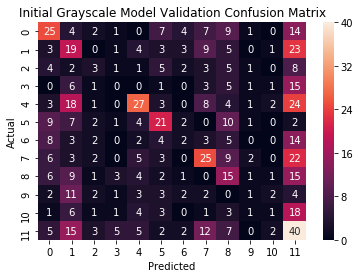

In [62]:
# Plot the validation confusion matrix for the initial grayscale model.
cm_gs=confusion_matrix(y_val_ind_gs, y_valPred_gs)
sns.heatmap(cm_gs, annot=True,  fmt='g', xticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] , yticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] )
plt.title("Initial Grayscale Model Validation Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### Grayscale Model Observations.
- The results are very poor and all over the place.
- The confusion matrix has no indication of a diagonal line which would form with better accuracy.
- It can be seen that the model becomes more overfit as the epochs increase.
- There is never a point where the validation accuracy is good at all. So the poor prediction is not just due to over fitting.
- I think that the pebbles are creating too many edges and that the colour is needed to distinguish the leaves better.

### 3a Make Data Compatible (RGB)

In [46]:
# Y Data is already prepared.
# New X data must be made from the gaussian blurred colour images.

In [47]:
# Check the shape of the X data.
images_rgb.shape

(4750, 128, 128, 3)

In [48]:
# Split the data into training, validation sets.
X_train_rgb, X_test_rgb, y_train_rgb, y_test_rgb = train_test_split(images_rgb, labels_array, test_size=0.3, random_state=9, stratify=labels_ohe)

In [49]:
# Split the test data into validation and test datasets.
X_val_rgb, X_test_rgb, y_val_rgb, y_test_rgb = train_test_split(X_test_rgb, y_test_rgb, test_size=0.5, random_state=9, stratify=y_test_rgb)

In [50]:
print("X_train shape:\t" + str(X_train_rgb.shape))
print("y_train shape:\t" + str(y_train_rgb.shape))
print("X_val shape:\t" + str(X_val_rgb.shape))
print("y_val shape:\t" + str(y_val_rgb.shape))
print("X_test shape:\t" + str(X_test_rgb.shape))
print("y_test shape:\t" + str(y_test_rgb.shape))

X_train shape:	(3325, 128, 128, 3)
y_train shape:	(3325, 12)
X_val shape:	(712, 128, 128, 3)
y_val shape:	(712, 12)
X_test shape:	(713, 128, 128, 3)
y_test shape:	(713, 12)


In [51]:
# Confirm that image array values are between 0 and 1.
print("X_train min and max:\t" + str(X_train_rgb.min()) + " " + str(X_train_rgb.max()))
print("X_val min and max:\t" + str(X_val_rgb.min()) + " " + str(X_val_rgb.max()))
print("X_test min and max:\t" + str(X_test_rgb.min()) + " " + str(X_test_rgb.max()))

X_train min and max:	0.0 0.9991353
X_val min and max:	0.0 0.99941033
X_test min and max:	0.0 0.99656814


### 4b Model Building (RGB)

In [52]:
# Build the model.
model_rgb = Sequential()
model_rgb.add(Conv2D(filters=32, kernel_size=3, activation="relu", input_shape=(128, 128, 3), data_format='channels_last'))
model_rgb.add(Conv2D(filters=32, kernel_size=3, activation="relu"))
model_rgb.add(Flatten())
model_rgb.add(Dense(128, activation="relu"))
model_rgb.add(Dense(12, activation="softmax"))

In [53]:
# Compile the model.
model_rgb.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")

In [54]:
# View the model summary.
model_rgb.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 124, 124, 32)      9248      
_________________________________________________________________
flatten_1 (Flatten)          (None, 492032)            0         
_________________________________________________________________
dense_2 (Dense)              (None, 128)               62980224  
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1548      
Total params: 62,991,916
Trainable params: 62,991,916
Non-trainable params: 0
_________________________________________________________________


In [55]:
# Train the model.
history_rgb = model_rgb.fit(X_train_rgb, y_train_rgb, batch_size=32, epochs=10,  validation_data=(X_val_rgb, y_val_rgb), verbose=1)

Train on 3325 samples, validate on 712 samples
Epoch 1/10
3325/3325 [==============================] - 16s 5ms/sample - loss: 3.3385 - accuracy: 0.1759 - val_loss: 2.0560 - val_accuracy: 0.3160
Epoch 2/10
3325/3325 [==============================] - 15s 4ms/sample - loss: 1.8475 - accuracy: 0.3747 - val_loss: 1.7827 - val_accuracy: 0.3834
Epoch 3/10
3325/3325 [==============================] - 15s 5ms/sample - loss: 1.6279 - accuracy: 0.4463 - val_loss: 1.5941 - val_accuracy: 0.4663
Epoch 4/10
3325/3325 [==============================] - 15s 5ms/sample - loss: 1.3716 - accuracy: 0.5374 - val_loss: 1.7362 - val_accuracy: 0.4129
Epoch 5/10
3325/3325 [==============================] - 15s 5ms/sample - loss: 1.1463 - accuracy: 0.6310 - val_loss: 1.6021 - val_accuracy: 0.4930
Epoch 6/10
3325/3325 [==============================] - 15s 4ms/sample - loss: 0.8447 - accuracy: 0.7296 - val_loss: 1.8528 - val_accuracy: 0.4663
Epoch 7/10
3325/3325 [==============================] - 15s 4ms/sample 

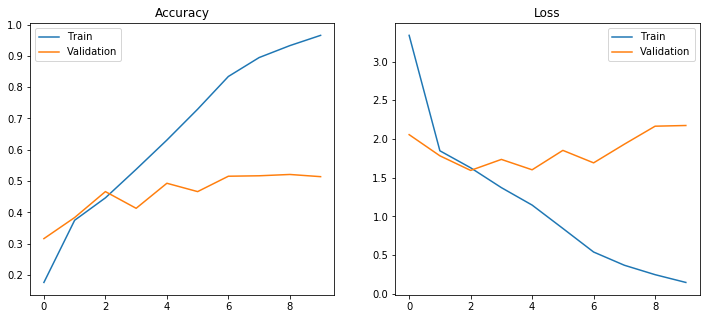

In [56]:
# Plot training history for initial RGB model.
plotFitHistory(history_rgb)

In [57]:
# Make predictions based on the validation X data.
y_valPred_rgb = model_rgb.predict_classes(X_val_rgb)

In [58]:
# Convert from one hot encoding to indices.
y_val_ind_rgb = np.argmax(y_val_rgb, axis=1)
y_val_ind_rgb[0:5]

array([ 7,  2, 11,  7,  4], dtype=int64)

In [59]:
# Get the loss and the accuracy 
loss_rgb, accuracy_rgb = model_rgb.evaluate(X_val_rgb, y_val_rgb, verbose=0)
print("Validation Accuracy:\t{:.4f}".format(accuracy_rgb))
print("Validation Loss:\t{:.4f}".format(loss_rgb))

Validation Accuracy:	0.5140
Validation Loss:	2.1742


In [82]:
print("Initial RGB Model Validation Classification Report")
print(classification_report(y_val_ind_rgb, y_valPred_rgb))

Initial RGB Model Validation Classification Report
              precision    recall  f1-score   support

           0       0.82      0.72      0.76        74
           1       0.30      0.38      0.34        71
           2       0.60      0.17      0.27        35
           3       0.22      0.18      0.20        33
           4       0.62      0.58      0.60        91
           5       0.69      0.81      0.74        59
           6       0.58      0.74      0.65        43
           7       0.50      0.56      0.53        77
           8       0.28      0.41      0.34        58
           9       0.67      0.30      0.42        33
          10       0.29      0.30      0.29        40
          11       0.63      0.53      0.57        98

    accuracy                           0.51       712
   macro avg       0.52      0.47      0.48       712
weighted avg       0.54      0.51      0.51       712



Text(0.5, 15.0, 'Predicted')

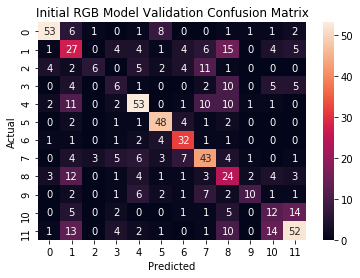

In [64]:
cm_rgb=confusion_matrix(y_val_ind_rgb, y_valPred_rgb)
sns.heatmap(cm_rgb, annot=True,  fmt='g', xticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] , yticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] )
plt.title("Initial RGB Model Validation Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

#### RGB Model Observations:
- The results are much better than the grayscale model.
- The validation accuracy seems to reach a maximum value and then drops as the model becomes overfit.
- The confusion matrix looks much more like it should, with the diagonal clearly visible.

### 5 Fit and Evaluate Model (Refined Model)

In [65]:
# Continue with the RGB model, add some more layers to try and reduce overfitting and to get good results.
# Building the model was an iterative process, I ommitted showing each iteration and instead only show the model which I ended up with.
model_ref = Sequential()

model_ref.add(Conv2D(filters=32, kernel_size=3, padding='same', activation="relu", input_shape=(128, 128, 3), data_format='channels_last'))
model_ref.add(MaxPooling2D(pool_size=(2, 2)))
model_ref.add(Dropout(rate=0.3))

model_ref.add(Conv2D(filters=32, kernel_size=3, padding='same', activation="relu"))
model_ref.add(MaxPooling2D(pool_size=(2, 2)))
model_ref.add(Dropout(rate=0.2))

model_ref.add(Conv2D(filters=64, kernel_size=3, padding='same', activation="relu"))
model_ref.add(MaxPooling2D(pool_size=(2, 2)))
model_ref.add(Dropout(rate=0.1))

model_ref.add(Conv2D(filters=64, kernel_size=3, padding='same', activation="relu"))
model_ref.add(MaxPooling2D(pool_size=(2, 2)))
model_ref.add(Dropout(rate=0.1))

model_ref.add(GlobalMaxPooling2D())
model_ref.add(Flatten())
model_ref.add(Dense(512, activation="relu"))
model_ref.add(Dropout(rate=0.1))
model_ref.add(Dense(256, activation="relu"))
model_ref.add(Dropout(rate=0.1))
model_ref.add(Dense(128, activation="relu"))
model_ref.add(Dropout(rate=0.1))
model_ref.add(Dense(12, activation="softmax"))

In [66]:
# Compile the model.
model_ref.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer="adam")
# View the model summary.
model_ref.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 64, 64, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 32, 32, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 32, 32, 64)       

In [67]:
# Train the model.
history_ref = model_ref.fit(X_train_rgb, y_train_rgb, batch_size=32, epochs=30,  validation_data=(X_val_rgb, y_val_rgb), verbose=1)

Train on 3325 samples, validate on 712 samples
Epoch 1/30
3325/3325 [==============================] - 8s 2ms/sample - loss: 2.4360 - accuracy: 0.1236 - val_loss: 2.4204 - val_accuracy: 0.1278
Epoch 2/30
3325/3325 [==============================] - 6s 2ms/sample - loss: 2.1655 - accuracy: 0.2397 - val_loss: 1.8399 - val_accuracy: 0.3722
Epoch 3/30
3325/3325 [==============================] - 6s 2ms/sample - loss: 1.8205 - accuracy: 0.3248 - val_loss: 1.7529 - val_accuracy: 0.3848
Epoch 4/30
3325/3325 [==============================] - 6s 2ms/sample - loss: 1.7513 - accuracy: 0.3540 - val_loss: 1.7378 - val_accuracy: 0.3483
Epoch 5/30
3325/3325 [==============================] - 6s 2ms/sample - loss: 1.6795 - accuracy: 0.3823 - val_loss: 1.6216 - val_accuracy: 0.4045
Epoch 6/30
3325/3325 [==============================] - 6s 2ms/sample - loss: 1.5256 - accuracy: 0.4382 - val_loss: 1.5573 - val_accuracy: 0.4593
Epoch 7/30
3325/3325 [==============================] - 6s 2ms/sample - loss:

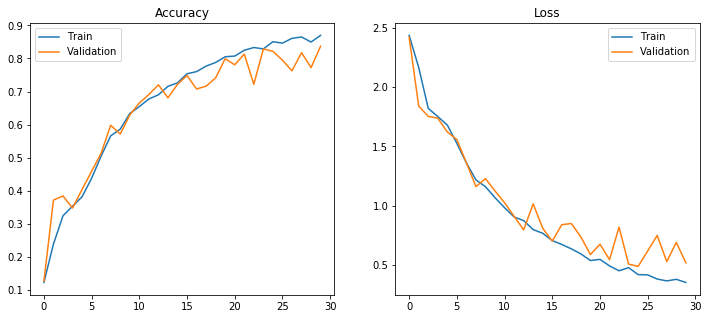

In [68]:
# Plot training history for refined model.
plotFitHistory(history_ref)

In [69]:
# Make predictions based on the validation X data.
y_valPred_ref = model_ref.predict_classes(X_val_rgb)
# Convert from one hot encoding to indices.
y_val_ind_ref = np.argmax(y_val_rgb, axis=1)

In [71]:
# Get the training loss and the accuracy 
trainLoss_ref, trainAccuracy_ref = model_ref.evaluate(X_train_rgb, y_train_rgb, verbose=0)
print("Training Accuracy:\t{:.4f}".format(trainAccuracy_ref))
print("Training Loss:\t\t{:.4f}".format(trainLoss_ref))

Training Accuracy:	0.8884
Training Loss:		0.3034


In [73]:
# Get the validation loss and the accuracy 
validationLoss_ref, validationAccuracy_ref = model_ref.evaluate(X_val_rgb, y_val_rgb, verbose=0)
print("Validation Accuracy:\t{:.4f}".format(validationAccuracy_ref))
print("Validation Loss:\t{:.4f}".format(validationLoss_ref))

Validation Accuracy:	0.8371
Validation Loss:	0.5185


In [74]:
print("Refined Model Validation Classification Report")
print(classification_report(y_val_ind_ref, y_valPred_ref))

=== Validation Classification Report for Refined Model===
              precision    recall  f1-score   support

           0       0.98      0.86      0.92        74
           1       0.97      0.79      0.87        71
           2       0.72      0.74      0.73        35
           3       0.74      0.94      0.83        33
           4       0.94      0.97      0.95        91
           5       0.94      0.86      0.90        59
           6       0.75      0.88      0.81        43
           7       0.73      0.92      0.82        77
           8       0.94      0.81      0.87        58
           9       1.00      0.61      0.75        33
          10       0.58      0.28      0.37        40
          11       0.74      0.95      0.83        98

    accuracy                           0.84       712
   macro avg       0.84      0.80      0.80       712
weighted avg       0.85      0.84      0.83       712



Text(0.5, 15.0, 'Predicted')

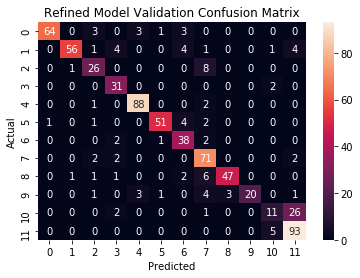

In [75]:
cm_rgb=confusion_matrix(y_val_ind_ref, y_valPred_ref)
sns.heatmap(cm_rgb, annot=True,  fmt='g', xticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] , yticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] )
plt.title("Refined Model Validation Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

In [76]:
# There are numerous instances of class 10 incorrectly classified as class 11.
# There are also quite a few instances of class 11 incorrectly classified as class 10.
# If these can be corrected then that will increase the accuracy.
# Find these instances.
class10IncorrectAs11 = []
class11IncorrectAs10 = []
for i in range(len(y_valPred_ref)):
    if((y_val_ind_ref[i] == 10) and (y_valPred_ref[i] == 11)):
        class10IncorrectAs11.append(i)
    elif ((y_val_ind_ref[i] == 11) and (y_valPred_ref[i] == 10)):
        class11IncorrectAs10.append(i)

Example images from  Loose Silky-bent


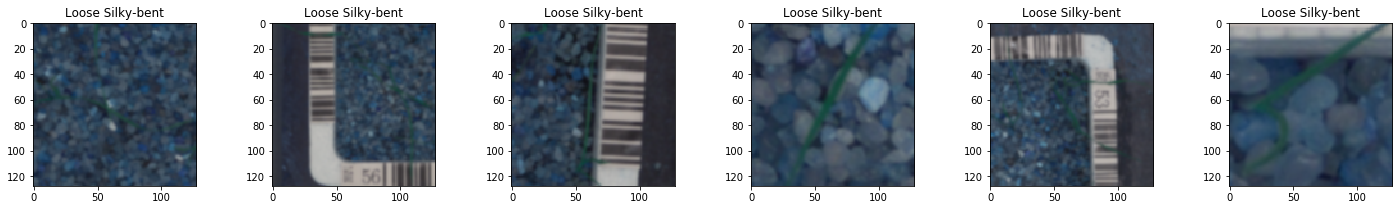

In [77]:
# print some pictures of class 11 to compare to the incorrect classifications of class 10.
print("Example images from ", classNames[11])
printImages(images_rgb, labelsList, np.array(range(classPositions[11],classPositions[11]+6, 1)), picSize=3)

Images from  Black-grass  incorrectly classified as  Loose Silky-bent


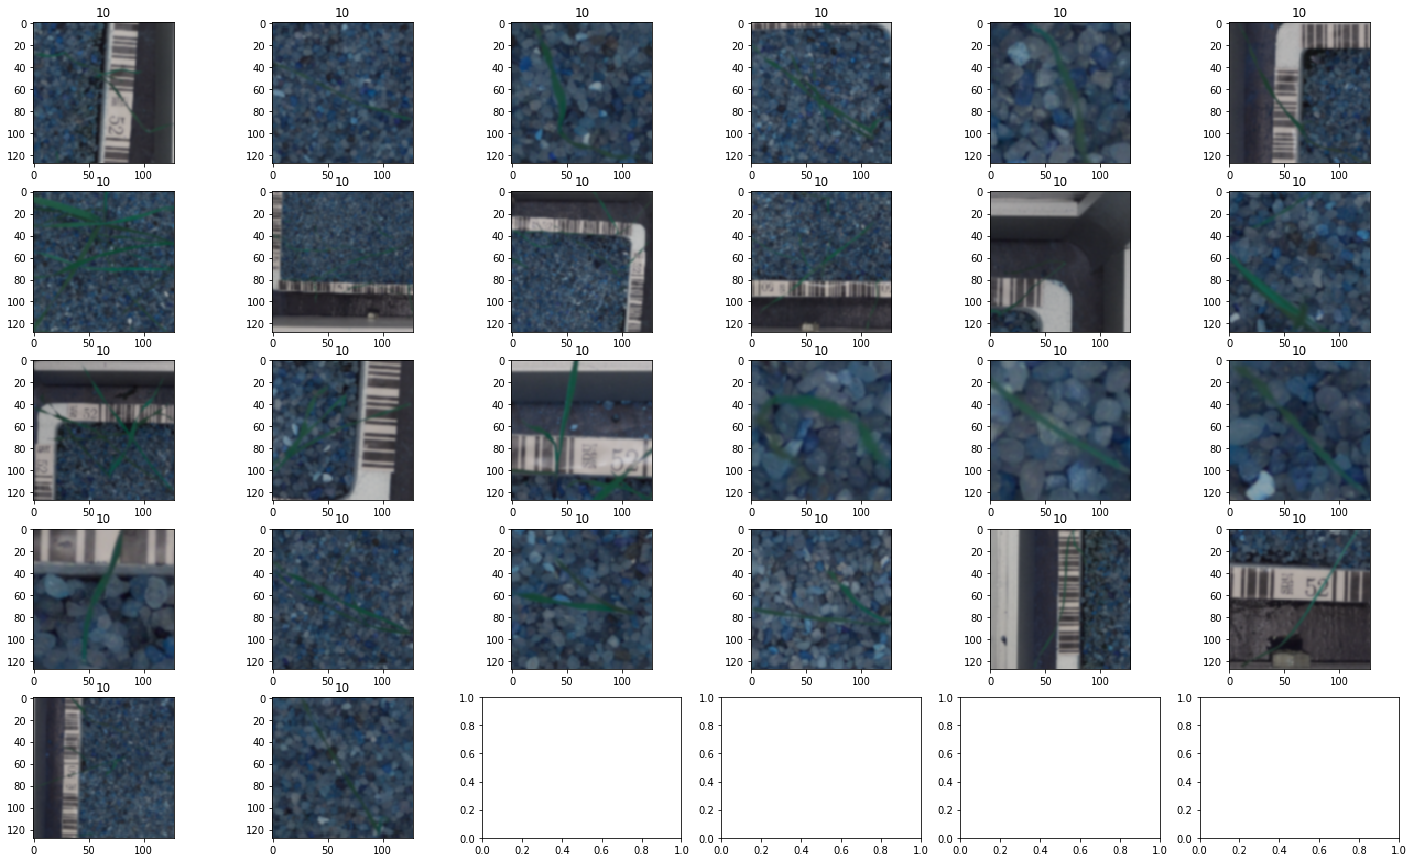

In [78]:
# Print the incorrectly predicted images from class 10.
print("Images from ", classNames[10], " incorrectly classified as ", classNames[11])
printImages(X_val_rgb, y_val_ind_ref, class10IncorrectAs11, picSize=3)

Example images from  Black-grass


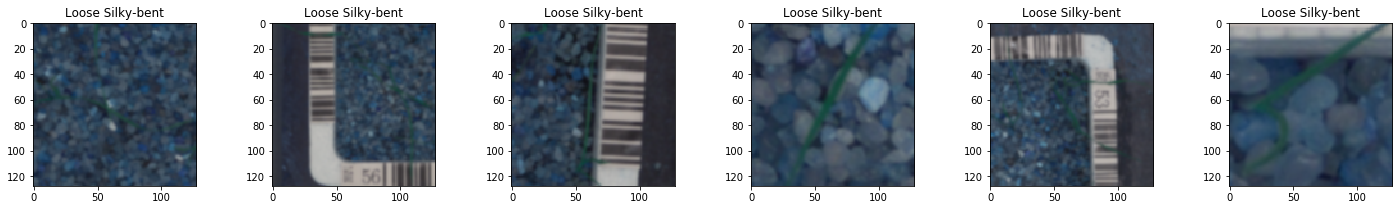

In [79]:
# Print some pictures of class 10 to compare to the incorrect classifications of class 11.
print("Example images from ", classNames[10])
printImages(images_rgb, labelsList, np.array(range(classPositions[11],classPositions[11]+6, 1)), picSize=3)

Images from  Loose Silky-bent  incorrectly classified as  Black-grass


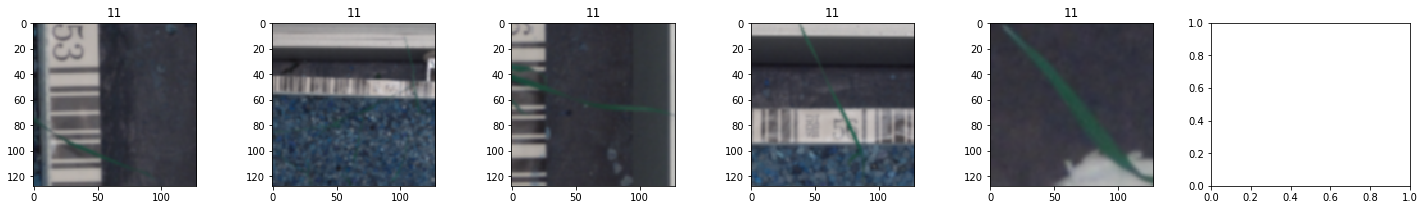

In [80]:
# Print the incorrectly predicted images from class 11.
print("Images from ", classNames[11], " incorrectly classified as ", classNames[10])
printImages(X_val_rgb, y_val_ind_ref, class11IncorrectAs10, picSize=3)

In [79]:
# It is easy to see why these are two classes are easily confused with each other. Both are a thin blade lea plant.
# classifying these images into the correct class probably requires advance techniques or just better images.

#### Evaluate the model on the test data

In [84]:
# Make predictions based on the validation X data.
y_testPred_prob = model_ref.predict(X_test_rgb)
y_testPred_class = model_ref.predict_classes(X_test_rgb)
# Convert from one hot encoding to indices.
y_test_ind_ref = np.argmax(y_test_rgb, axis=1)
# Get the loss and the accuracy 
testLoss_ref, testAccuracy_ref = model_ref.evaluate(X_test_rgb, y_test_rgb, verbose=0)
print("Test Accuracy:\t{:.4f}".format(testAccuracy_ref))
print("Test Loss:\t{:.4f}".format(testLoss_ref))

Test Accuracy:	0.8163
Test Loss:	0.4960


In [85]:
print("Refined Model Test Classification Report")
print(classification_report(y_test_ind_ref, y_testPred_class))

Refined Model Test Classification Report
              precision    recall  f1-score   support

           0       0.99      0.88      0.93        75
           1       0.93      0.72      0.81        72
           2       0.70      0.76      0.73        34
           3       0.73      0.73      0.73        33
           4       0.98      0.87      0.92        92
           5       0.92      0.81      0.86        58
           6       0.71      0.84      0.77        43
           7       0.75      0.94      0.83        78
           8       0.89      0.93      0.91        58
           9       1.00      0.76      0.86        33
          10       0.43      0.15      0.23        39
          11       0.67      0.95      0.78        98

    accuracy                           0.82       713
   macro avg       0.81      0.78      0.78       713
weighted avg       0.82      0.82      0.81       713



Text(0.5, 15.0, 'Predicted')

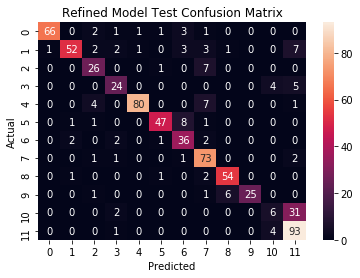

In [86]:
cmTest_rgb=confusion_matrix(y_test_ind_ref, y_testPred_class)
sns.heatmap(cmTest_rgb, annot=True,  fmt='g', xticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] , yticklabels = [0,1,2,3,4,5,6,7,8,9,10,11] )
plt.title("Refined Model Test Confusion Matrix")
plt.ylabel('Actual')
plt.xlabel('Predicted')

### 6 Visualize Some Predictions

In [94]:
def visualizePrediction(index):
    actualClass = y_test_ind_ref[index]
    predictedClass = y_testPred_class[index]
    print("Actual Class: ", actualClass)
    print("Actual Name: "+classNames[actualClass])
    plt.imshow(X_test_rgb[index])
    plt.show()
    print()
    
    print("Predicted Class: ", predictedClass)
    print("Predicted Name: "+classNames[predictedClass])
    print("Softmax Probability Prediction: ")
    print(y_testPred_prob[index])
    if(actualClass != predictedClass):
        print("Example of correct class")
        plt.imshow(images_rgb[classPositions[predictedClass]])
        plt.show()
    print()
    
    if(actualClass == predictedClass):
        print("Correct Prediction")
    else:
        print("Incorrect Prediction")
    print()
    

Actual Class:  9
Actual Name: Maize


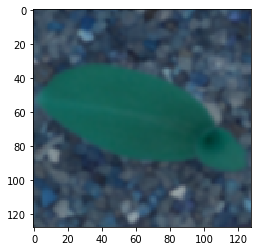


Predicted Class:  9
Predicted Name: Maize
Softmax Probability Prediction: 
[1.06478855e-02 3.50726349e-03 1.87769774e-02 1.76914199e-03
 3.97873893e-02 6.82650041e-03 1.23006538e-01 1.77341297e-01
 2.40138751e-02 5.91831565e-01 5.27442608e-04 1.96409808e-03]

Correct Prediction



In [95]:
visualizePrediction(2)

Actual Class:  1
Actual Name: Fat Hen


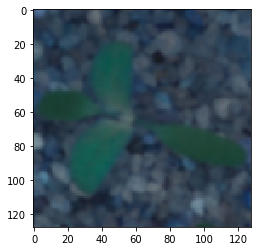


Predicted Class:  1
Predicted Name: Fat Hen
Softmax Probability Prediction: 
[1.7549072e-03 8.6463183e-01 1.7280590e-02 2.8931571e-04 1.6366342e-03
 5.0647428e-05 2.8887321e-03 5.2815963e-02 5.8197603e-02 6.2257728e-05
 1.7168252e-04 2.1982979e-04]

Correct Prediction



In [96]:
visualizePrediction(3)

Actual Class:  4
Actual Name: Common Chickweed


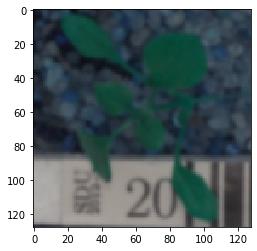


Predicted Class:  4
Predicted Name: Common Chickweed
Softmax Probability Prediction: 
[3.0084809e-02 1.2429383e-02 4.3730614e-01 5.5054479e-05 4.9408820e-01
 3.1966888e-04 2.6855667e-04 2.4223719e-02 8.3536207e-04 3.1988879e-04
 1.8398376e-05 5.0735587e-05]

Correct Prediction



In [97]:
visualizePrediction(33)

Actual Class:  7
Actual Name: Scentless Mayweed


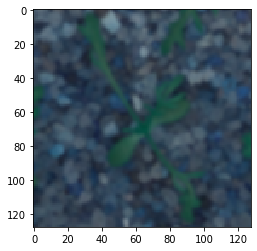


Predicted Class:  7
Predicted Name: Scentless Mayweed
Softmax Probability Prediction: 
[1.00282916e-04 7.91967846e-03 1.59349307e-04 4.82853829e-05
 1.36826784e-04 3.28592751e-06 1.04550469e-04 9.89442229e-01
 1.38191809e-03 7.58634087e-06 7.22385084e-05 6.23691827e-04]

Correct Prediction



In [98]:
visualizePrediction(36)

Actual Class:  4
Actual Name: Common Chickweed


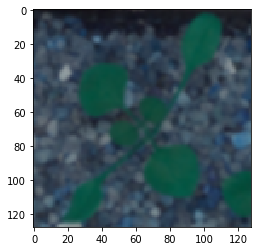


Predicted Class:  4
Predicted Name: Common Chickweed
Softmax Probability Prediction: 
[3.5297591e-03 3.0220867e-04 3.7088625e-02 1.4542874e-07 9.5847338e-01
 1.2872563e-06 1.3606382e-06 5.7411921e-04 1.3935991e-05 1.4793532e-05
 7.4266971e-08 3.0422254e-07]

Correct Prediction



In [99]:
visualizePrediction(59)

Actual Class:  11
Actual Name: Loose Silky-bent


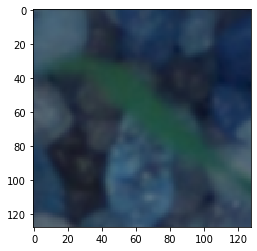


Predicted Class:  3
Predicted Name: Common wheat
Softmax Probability Prediction: 
[2.6221529e-03 2.9529901e-03 7.4218831e-04 4.4024548e-01 3.5029335e-04
 6.2431063e-05 2.5898320e-04 9.4866725e-03 1.6179822e-02 5.2238503e-03
 2.6169723e-01 2.6017794e-01]
Example of correct class


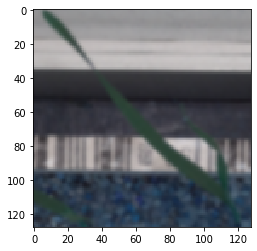


Incorrect Prediction

Actual Class:  10
Actual Name: Black-grass


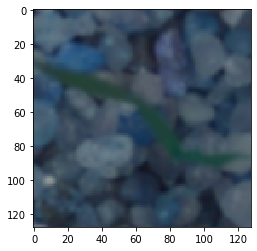


Predicted Class:  11
Predicted Name: Loose Silky-bent
Softmax Probability Prediction: 
[1.3680194e-03 1.5020862e-04 1.4972493e-06 1.0900084e-03 1.2472087e-05
 8.8480576e-08 1.0110934e-06 2.7307260e-04 3.6139000e-04 4.1592264e-04
 1.2848368e-01 8.6784250e-01]
Example of correct class


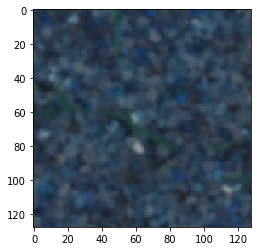


Incorrect Prediction

Actual Class:  5
Actual Name: Charlock


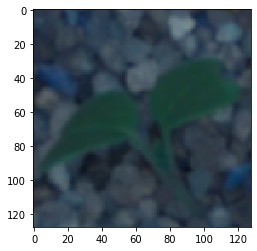


Predicted Class:  6
Predicted Name: Cleavers
Softmax Probability Prediction: 
[0.02449886 0.20219481 0.13346419 0.04262813 0.01249279 0.0385523
 0.39046395 0.07964701 0.07079128 0.00214262 0.001486   0.00163808]
Example of correct class


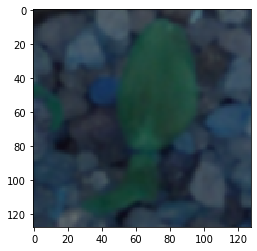


Incorrect Prediction

Actual Class:  5
Actual Name: Charlock


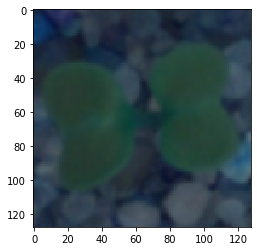


Predicted Class:  6
Predicted Name: Cleavers
Softmax Probability Prediction: 
[4.2768233e-03 1.2816167e-03 7.0996642e-02 1.0949491e-03 2.0112479e-03
 2.4800935e-01 4.1411400e-01 2.5275677e-01 4.8030596e-03 6.3354505e-04
 5.5219407e-06 1.6358068e-05]
Example of correct class


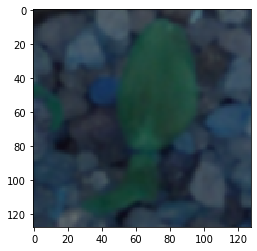


Incorrect Prediction

Actual Class:  10
Actual Name: Black-grass


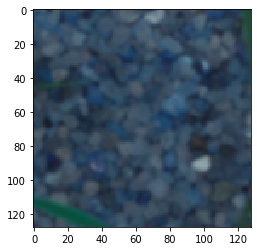


Predicted Class:  11
Predicted Name: Loose Silky-bent
Softmax Probability Prediction: 
[2.3635449e-04 2.2254126e-05 5.3771075e-08 7.9078585e-05 6.6139586e-07
 4.5540816e-09 9.0211714e-08 1.3231092e-04 1.5236723e-04 5.2108247e-05
 1.7801470e-01 8.2131004e-01]
Example of correct class


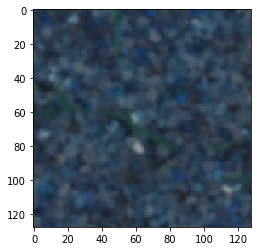


Incorrect Prediction



In [100]:
# Visualize some incorrect predictions.
maxCount = 5
count = 0
for i in range(len(y_testPred_class)):
    if(y_testPred_class[i] != y_test_ind_ref[i]):
        visualizePrediction(i)
        count += 1
        if(count == maxCount):
            break
        

### Summary

In [101]:
trainDict = {'Loss': trainLoss_ref, 'Accuracy': trainAccuracy_ref}
trainSeries = pd.Series(name='Training', data=trainDict)
valDict = {'Loss': validationLoss_ref, 'Accuracy': validationAccuracy_ref}
valSeries = pd.Series(name='Validation', data=valDict)
testDict = {'Loss': testLoss_ref, 'Accuracy': testAccuracy_ref}
testSeries = pd.Series(name='Testing', data=testDict)
summary_df = pd.DataFrame(columns=['Accuracy', 'Loss'])
summary_df = summary_df.append(trainSeries)
summary_df = summary_df.append(valSeries)
summary_df = summary_df.append(testSeries)

In [102]:
summary_df

Accuracy   Loss
Training      0.8884 0.3034
Validation    0.8371 0.5185
Testing       0.8163 0.4960